In [6]:
%reset
import os

# Change the current working directory to the desired path
os.chdir('/Users/shivam/Library/CloudStorage/Dropbox/research/GODMAX/src/')

# from get_BCMP_profile_jit import BCM_18_wP
# from get_KS_profile import KS_01
# from get_OBB_profile import OBB_nonconst
# from get_Battaglia_profile import Battaglia_12_16
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2




In [24]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['theta_co'] = 0.1
sim_params_dict['theta_ej'] = 4.0
sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['M1_starcga'] = 2.5e11
sim_params_dict['epsilon_rt'] = 4.0
sim_params_dict['Mc0'] = 10**14.83
# sim_params_dict['Mc0'] = 10**1
sim_params_dict['nu_z'] = 0
sim_params_dict['nu_M'] = 0
sim_params_dict['Mstar0'] = 10**13
sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.8
sim_params_dict['cosmo'] = cosmo_params_dict




In [30]:
halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 10, 35
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0, 2.5, 32
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e14, 1e15, 31
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 10, 16
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 32, 8192, 32
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.25
halo_params_dict['mdef'] = '200c'




In [31]:
# from jax_cosmo import Cosmology
# from jax_cosmo.power import linear_matter_power
# cosmo_jax = Cosmology(
#             Omega_c=cosmo_params_dict['Om0'] - cosmo_params_dict['Ob0'],
#             Omega_b=cosmo_params_dict['Ob0'],
#             h=cosmo_params_dict['H0'] / 100.,
#             sigma8=cosmo_params_dict['sigma8'],
#             n_s=cosmo_params_dict['ns'],
#             Omega_k=0.,
#             w0=cosmo_params_dict['w0'],
#             wa=0.
#             )
# z_array = jnp.linspace(0, 1, 10)
# a_array = 1./(1. + z_array)
# k_array = jnp.logspace(-3, 1, 100)
# pkz = vmap(linear_matter_power,(None, None, 0))(cosmo_jax, k_array, a_array)



In [32]:
# # pkz.shape
# pl.figure()
# pl.plot(k_array, pkz[0,:])
# pl.plot(k_array, pkz[5,:])
# pl.xscale('log')
# pl.yscale('log')


In [33]:
# %%time
# BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


cpu


In [34]:
from setup_power_spectra import setup_power_BCMP



In [35]:
%%time
setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict)




CPU times: user 2min 2s, sys: 1.49 s, total: 2min 3s
Wall time: 46.5 s


In [36]:
dndm_jax = setup_power_BCMP_test.hmf_Mz_mat




In [37]:
# setup_power_BCMP_test.z_array[0]
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)


In [38]:
from colossus.lss import mass_function
mfunc_so = mass_function.massFunction(setup_power_BCMP_test.M_array, 0.0, q_out = 'dndlnM', mdef = '200c', model = 'tinker08') 
mfunc_so_fsigma = mass_function.massFunction(setup_power_BCMP_test.M_array, 0.0, mdef = '200c', model = 'tinker08') 




In [39]:
fsigma = setup_power_BCMP_test.fsigma_Mz_mat[0,:]



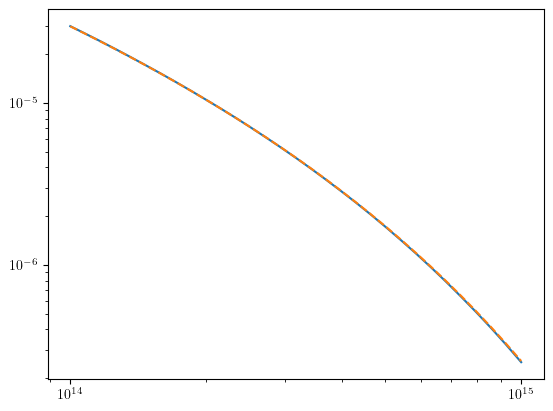

In [40]:
# dndm_jax.shape
pl.figure()
pl.plot(setup_power_BCMP_test.M_array, dndm_jax[0,:])
pl.plot(setup_power_BCMP_test.M_array, mfunc_so, ls='--')
pl.xscale('log')
pl.yscale('log')




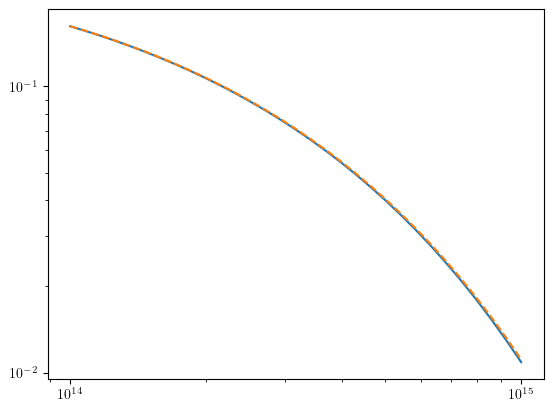

In [41]:
# dndm_jax.shape
pl.figure()
pl.plot(setup_power_BCMP_test.M_array, fsigma)
pl.plot(setup_power_BCMP_test.M_array, mfunc_so_fsigma, ls='--')
pl.xscale('log')
pl.yscale('log')




In [42]:
from colossus.lss import bias
bM = bias.haloBias(setup_power_BCMP_test.M_array, 0.0, mdef='200c', model='tinker10')



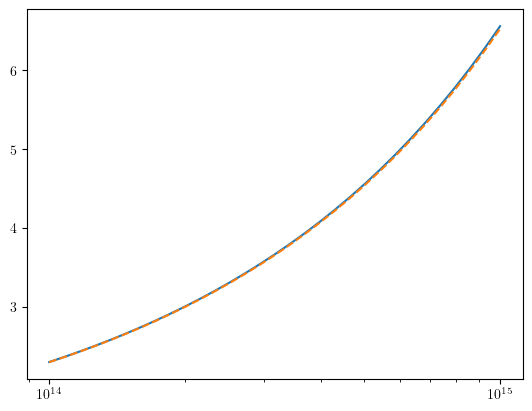

In [45]:
# dndm_jax.shape
pl.figure()
pl.plot(setup_power_BCMP_test.M_array, setup_power_BCMP_test.bias_Mz_mat[0,:])
pl.plot(setup_power_BCMP_test.M_array, bM, ls='--')
pl.xscale('log')
# pl.yscale('log')





In [170]:
# from colossus.lss import mass_function
# jz = 50
# jM = 20
# mfunc_so = mass_function.massFunction(setup_power_BCMP_test.M_array[jM], setup_power_BCMP_test.z_array[jz], q_out='dndlnM', mdef = '200c', model = 'tinker08')
# print(mfunc_so, setup_power_BCMP_test.hmf_Mz_mat[jz, jM])




In [171]:
# jk = 50
# jz = 0
# print(setup_power_BCMP_test.kPk_array[jk])
# cmean_jz = setup_power_BCMP_test.conc_Mz_mat[jz, :]
# logc_array = jnp.log(setup_power_BCMP_test.conc_array)
# sig_logc = setup_power_BCMP_test.sig_logc_z_array[jz]
# conc_mat = jnp.tile(setup_power_BCMP_test.conc_array, (setup_power_BCMP_test.nM, 1))
# cmean_jz_mat = jnp.tile(cmean_jz, (setup_power_BCMP_test.nc, 1)).T
# p_logc_Mz = jnp.exp(-0.5 * (jnp.log(conc_mat/cmean_jz_mat)/ sig_logc)**2) * (1.0/(sig_logc * jnp.sqrt(2*jnp.pi)))

# fx = ((setup_power_BCMP_test.uk_nfw_Pk[jk,:,jz,:])**2).T * p_logc_Mz
# ukz_intc = jnp.trapz(fx, x=logc_array)
# dndM_z = setup_power_BCMP_test.hmf_Mz_mat[jz, :]     
# rhom_z = setup_power_BCMP_test.get_rho_m(setup_power_BCMP_test.z_array[jz])
# fx = ukz_intc * dndM_z * ((setup_power_BCMP_test.M_array/rhom_z)**2) * setup_power_BCMP_test.M_array
# Pmm_1h = jnp.trapz(fx, x=jnp.log(setup_power_BCMP_test.M_array))
# print(ukz_intc, dndM_z)


In [172]:
# R = (3.0 * setup_power_BCMP_test.M_array[jM] / 4.0 / np.pi / setup_power_BCMP_test.get_rho_m(0.0))**(1.0 / 3.0)
# cosmo.sigma(R,z), sigma
    
    

In [173]:
# pl.figure()
# pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0])
# pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0])
# pl.xscale('log')
# pl.yscale('log')



In [174]:
# setup_power_BCMP_test.plin_kz_mat.shape


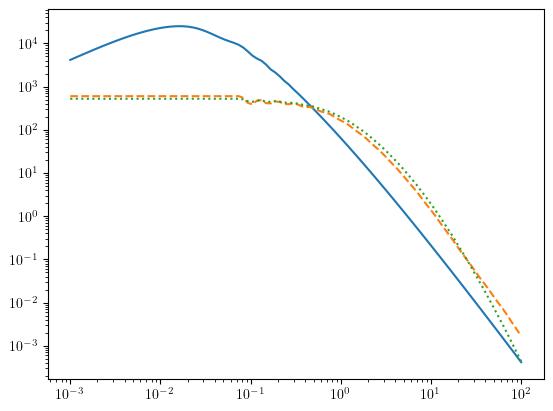

In [49]:
pl.figure()
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.plin_kz_mat[:,0])
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0], ls='--')
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0], ls=':')
pl.xscale('log')
pl.yscale('log')



(0.69, 1.5)

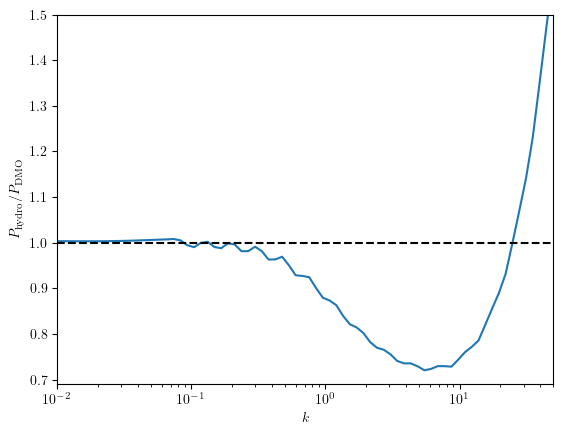

In [47]:
Pk_nfw = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0]
Pk_dmb = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0]
pl.figure()
pl.plot(setup_power_BCMP_test.kPk_array, (Pk_dmb)/Pk_nfw)
pl.xscale('log')
pl.axhline(1.0, color='k', ls='--')
pl.xlim(1e-2, 50)
pl.xlabel(r'$k$')
pl.ylabel(r'$P_{\rm hydro}/P_{\rm DMO}$')
pl.ylim(0.69,1.5)
# pl.yscale('log')




In [110]:
setup_power_BCMP_test.Pmm_dmb_1h_mat.shape


(100, 64)

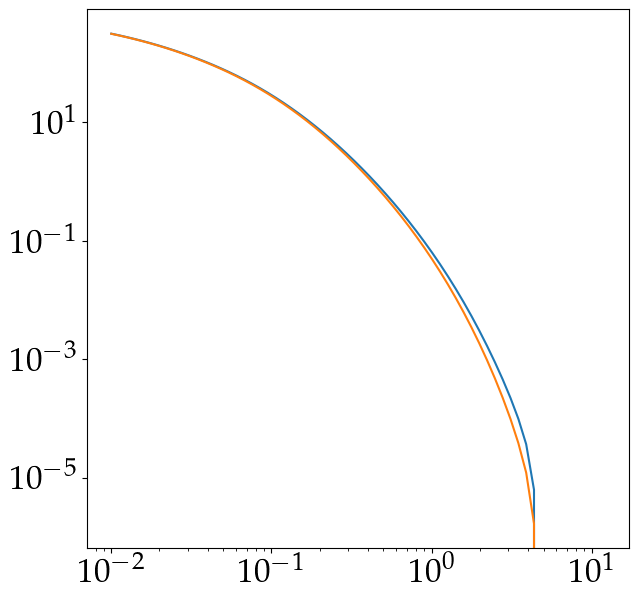

In [63]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,0,0,0])
pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




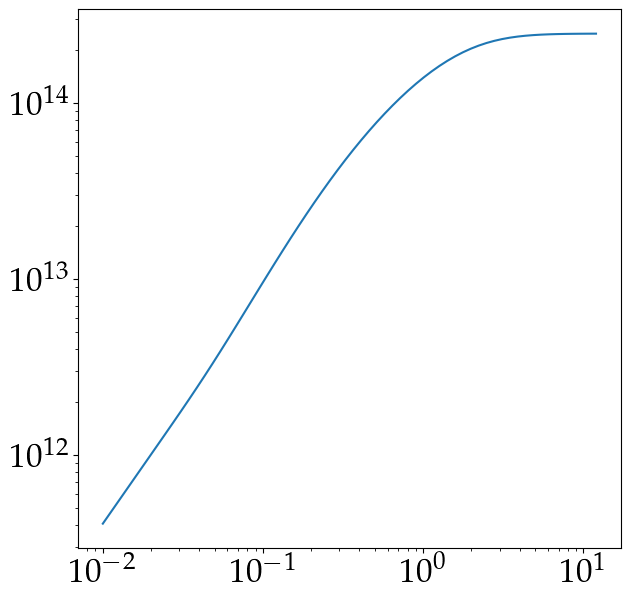

In [64]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Mdmb_mat[:,0,0,0])
# pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




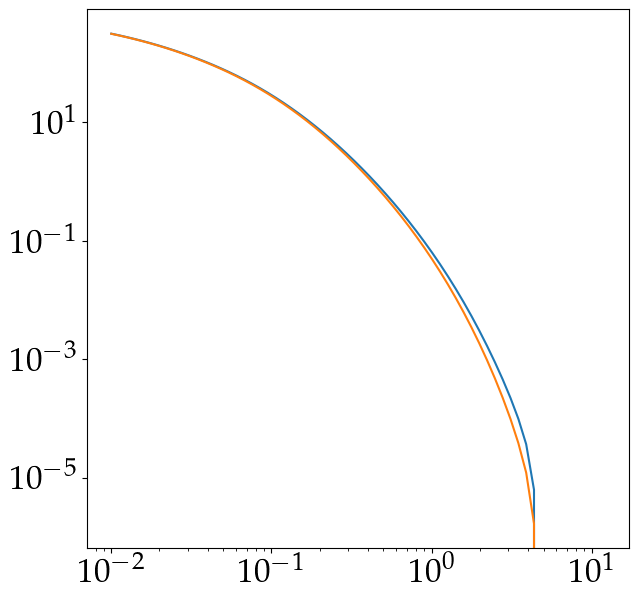

In [65]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,0,0,0])
pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




In [66]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_gas_normed, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_gas_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 171 ms


In [67]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_clm, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_clm_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 759 ms, sys: 16.4 ms, total: 775 ms
Wall time: 422 ms


In [68]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_cga, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_cga_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 153 ms


In [69]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_dmb, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_dmb_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 922 ms, sys: 36.1 ms, total: 959 ms
Wall time: 543 ms


In [94]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_nfw_normed, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_nfw_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 153 ms, sys: 4.86 ms, total: 158 ms
Wall time: 196 ms


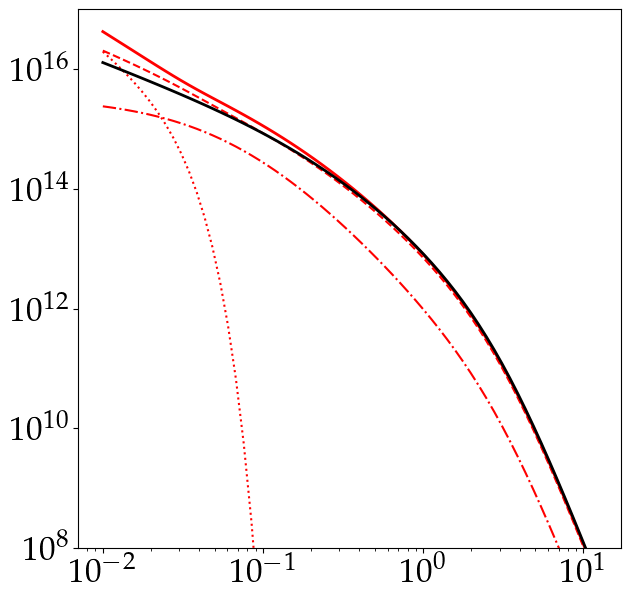

In [71]:
pl.figure()
pl.plot(BCMP_test.r_array, rho_gas_normed_mat[:,0,0,0], ls='-.', color='r')
pl.plot(BCMP_test.r_array, rho_clm_normed_mat[:,0,0,0], ls='--', color='r')
pl.plot(BCMP_test.r_array, rho_cga_normed_mat[:,0,0,0], ls=':', color='r')
pl.plot(BCMP_test.r_array, rho_dmb_normed_mat[:,0,0,0], ls='-', color='r', lw=2)
pl.plot(BCMP_test.r_array, rho_nfw_normed_mat[:,0,0,0], ls='-', color='k', lw=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e8, 1e17)
pl.show()






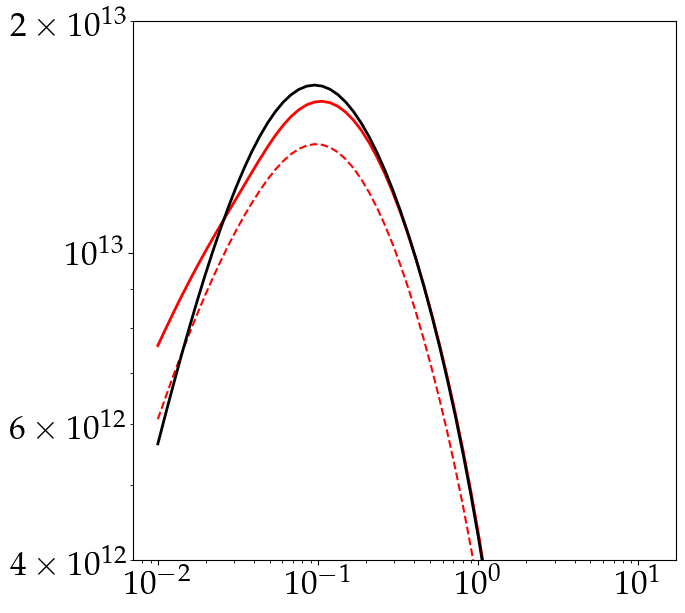

In [77]:
pl.figure()
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_gas_normed_mat[:,-5,0,0], ls='-.', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_clm_normed_mat[:,-5,0,0], ls='--', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_cga_normed_mat[:,-5,0,0], ls=':', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_dmb_normed_mat[:,-5,0,0], ls='-', color='r', lw=2)
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_nfw_normed_mat[:,-5,0,0], ls='-', color='k', lw=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(4e12,2e13)
# pl.ylim(1e8, 1e17)
pl.show()






In [91]:
# BCMP_test.conc_array[-5]
from mcfit import xi2P


In [104]:
Mtot_rep = jnp.repeat(BCMP_test.Mtot_mat[None, :, :, :], len(BCMP_test.r_array), axis=0)


In [103]:
BCMP_test.Mtot_mat.shape


(16, 64, 64)

In [109]:
k, P_nfw = xi2P(BCMP_test.r_array)(BCMP_test.rho_nfw_mat/Mnfw_rep, axis=0)



In [108]:
k, P_dmb = xi2P(BCMP_test.r_array)(BCMP_test.rho_dmb_mat/Mnfw_rep, axis=0)



In [128]:
window = jnp.ones(5) / 5
y_smooth = jnp.convolve(P_nfw[:,-5,0,0], window, mode='same')



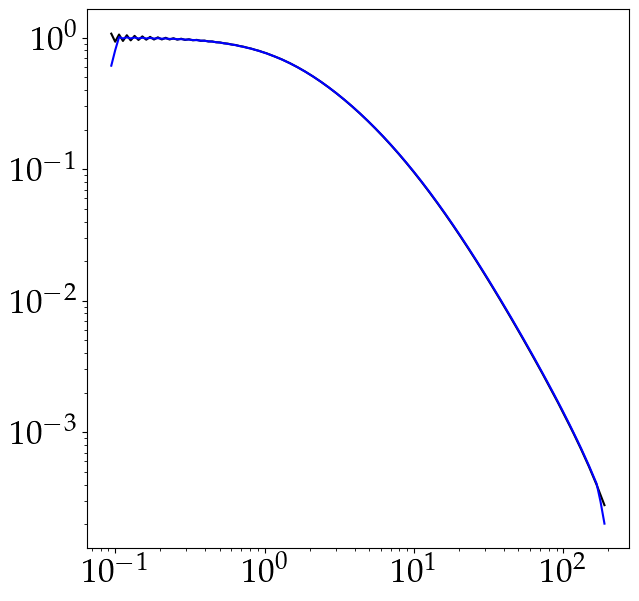

In [131]:
pl.figure()
indc = 3
window = jnp.ones(5) / 5
# pl.plot(k, (k**3) * P_nfw[:,indc,0,0], color='k')
# pl.plot(k, (k**3) * jnp.convolve(P_nfw[:,indc,0,0], window, mode='same'), color='b')
pl.plot(k, P_nfw[:,indc,0,0], color='k')
pl.plot(k, jnp.convolve(P_nfw[:,indc,0,0], window, mode='same'), color='b')

pl.xscale('log')
pl.yscale('log')




In [ ]:
from jax_cosmo.power import sigmasqr

